In [2]:
# Import các thư viện cần thiết
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import Levenshtein

from model_cnn_transformer import OCRModel
from dataset_polygon import char2idx, idx2char

# Thiết lập hiển thị hình ảnh trong notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
# --- Cấu hình ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VOCAB_SIZE = len(char2idx)
MODEL_PATH = "models/best_ocr_model.pth"
LABEL_DIR = os.path.join("vietnamese", "labels")

print(f"Device: {DEVICE}")
print(f"Vocabulary size: {VOCAB_SIZE}")

Device: cpu
Vocabulary size: 231


In [4]:
# --- Xác định token SOS ---
SOS_TOKEN = None
for token in char2idx.keys():
    if "SOS" in token:
        SOS_TOKEN = token
        print(f"Found SOS token: '{SOS_TOKEN}'")
        break

if SOS_TOKEN is None:
    raise ValueError("SOS token not found in vocabulary!")

Found SOS token: '<SOS>'


In [5]:
# --- Tải mô hình ---
model = OCRModel(vocab_size=VOCAB_SIZE).to(DEVICE)

try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"Loaded model from {MODEL_PATH}")
except FileNotFoundError:
    alt_model_path = "ocr_model.pth"
    model.load_state_dict(torch.load(alt_model_path, map_location=DEVICE))
    print(f"Could not find {MODEL_PATH}, loaded model from {alt_model_path} instead")

model.eval()

Loaded model from models/best_ocr_model.pth


OCRModel(
  (encoder): CNNEncoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=

In [6]:
# --- Các hàm hỗ trợ ---
def preprocess_image(img_path, box=None):
    """Tiền xử lý ảnh cho mô hình"""
    image = Image.open(img_path).convert("RGB")

    # Nếu có bounding box, cắt ảnh
    if box:
        x1, y1, x2, y2 = box
        image = image.crop((x1, y1, x2, y2))

    transform = transforms.Compose(
        [
            transforms.Resize((32, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    return transform(image).unsqueeze(0)


def decode_sequence(indices):
    """Chuyển đổi chỉ số thành ký tự"""
    chars = []
    for idx in indices:
        ch = idx2char.get(idx, "")
        if ch == "<EOS>":
            break
        if ch not in ("<PAD>", SOS_TOKEN):
            chars.append(ch)
    return "".join(chars)


def greedy_decode(model, image_tensor):
    """Giải mã chuỗi từ đặc trưng ảnh"""
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(DEVICE)
        memory = model.encoder(image_tensor)
        ys = torch.tensor([[char2idx[SOS_TOKEN]]], device=DEVICE)

        for i in range(36):  # MAX_LEN
            out = model.decoder(
                ys,
                memory,
                tgt_mask=model.generate_square_subsequent_mask(ys.size(1)).to(DEVICE),
            )

            prob = out[:, -1, :]
            _, next_word = torch.max(prob, dim=1)
            ys = torch.cat([ys, next_word.unsqueeze(1)], dim=1)

            if next_word.item() == char2idx["<EOS>"]:
                break

        return decode_sequence(ys.squeeze(0).tolist())


def get_label_from_image_id(img_id):
    """Lấy ground truth từ file nhãn"""
    label_path = os.path.join(LABEL_DIR, f"gt_{img_id}.txt")
    if not os.path.exists(label_path):
        return None

    with open(label_path, encoding="utf-8") as f:
        labels = []
        for line in f:
            parts = line.strip().split(",")
            if len(parts) < 9 or parts[8] == "###":
                continue
            polygon = list(map(int, parts[:8]))
            text_gt = parts[8]

            # Tính toán bounding box
            x_coords, y_coords = polygon[::2], polygon[1::2]
            x1, y1, x2, y2 = min(x_coords), min(y_coords), max(x_coords), max(y_coords)

            labels.append({"text": text_gt, "box": (x1, y1, x2, y2)})

    return labels


def calculate_metrics(ground_truth, prediction):
    """Tính toán các metrics đánh giá"""
    edit_distance = Levenshtein.distance(ground_truth, prediction)
    cer = edit_distance / max(len(ground_truth), 1)

    # Word Accuracy
    word_accuracy = 1.0 if ground_truth == prediction else 0.0

    # Character Accuracy
    min_len = min(len(ground_truth), len(prediction))
    char_matches = sum(1 for i in range(min_len) if ground_truth[i] == prediction[i])
    char_accuracy = char_matches / max(len(ground_truth), len(prediction), 1)

    return {
        "edit_distance": edit_distance,
        "cer": cer,
        "word_accuracy": word_accuracy,
        "char_accuracy": char_accuracy,
    }

In [7]:
def predict_image(img_path):
    """Dự đoán văn bản từ ảnh và so sánh với ground truth"""
    # Kiểm tra đường dẫn
    if not os.path.exists(img_path):
        print(f"Lỗi: Không tìm thấy file {img_path}")
        return

    # Lấy image ID từ tên file
    img_filename = os.path.basename(img_path)
    img_id = img_filename.replace("im", "").replace(".jpg", "")

    try:
        img_id = int(img_id)
        print(f"ID ảnh: {img_id}")
    except ValueError:
        print(f"Không thể trích xuất ID từ tên file: {img_filename}")
        return

    # Lấy ground truth từ file nhãn
    labels = get_label_from_image_id(img_id)

    if not labels:
        print(f"Không tìm thấy nhãn cho ảnh ID: {img_id}")

        # Dự đoán trên toàn bộ ảnh nếu không có nhãn
        img = cv2.imread(img_path)
        if img is None:
            print(f"Lỗi: Không thể đọc ảnh {img_path}")
            return

        # Hiển thị ảnh gốc
        plt.figure(figsize=(12, 8))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f"Ảnh: {img_filename}")
        plt.axis("off")
        display(plt.gcf())
        plt.close()

        # Dự đoán
        image_tensor = preprocess_image(img_path)
        pred_text = greedy_decode(model, image_tensor)
        print(f"Dự đoán: {pred_text}")

        return

    # Đọc ảnh
    img = cv2.imread(img_path)
    if img is None:
        print(f"Lỗi: Không thể đọc ảnh {img_path}")
        return

    print(f"Tìm thấy {len(labels)} vùng chữ trong ảnh")

    # Hiển thị ảnh gốc
    plt.figure(figsize=(12, 8))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Vẽ bounding box lên ảnh gốc
    for label_data in labels:
        x1, y1, x2, y2 = label_data["box"]
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.imshow(img_rgb)
    plt.title(f"Ảnh gốc: {img_filename} với {len(labels)} vùng chữ")
    plt.axis("off")
    display(plt.gcf())
    plt.close()

    # Hiển thị kết quả cho từng vùng chữ
    num_labels = len(labels)
    all_results = []

    # List lưu tất cả văn bản dự đoán
    all_texts = {
        "ground_truth": [],
        "predictions": [],
    }

    for i, label_data in enumerate(labels):
        text_gt = label_data["text"]
        x1, y1, x2, y2 = label_data["box"]

        # Đảm bảo tọa độ hợp lệ
        height, width = img.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(width, x2), min(height, y2)

        if x1 >= x2 or y1 >= y2:
            print(f"Cảnh báo: Vùng cắt không hợp lệ: {x1},{y1},{x2},{y2}")
            continue

        # Cắt vùng chữ
        img_crop = img[y1:y2, x1:x2]
        if img_crop.size == 0:
            continue

        img_rgb = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)

        # Dự đoán
        image_tensor = preprocess_image(img_path, (x1, y1, x2, y2))
        pred_text = greedy_decode(model, image_tensor)

        # Lưu văn bản dự đoán
        all_texts["ground_truth"].append(text_gt)
        all_texts["predictions"].append(pred_text)

        # Tính metrics
        metrics = calculate_metrics(text_gt, pred_text)
        all_results.append({"gt": text_gt, "pred": pred_text, "metrics": metrics})

        # Hiển thị kết quả với một figure riêng cho mỗi vùng chữ
        plt.figure(figsize=(8, 4))
        plt.imshow(img_rgb)
        plt.title(
            f"Vùng chữ #{i+1}:\nGround truth: {text_gt}\nDự đoán: {pred_text}\nCER: {metrics['cer']:.4f}, Acc: {metrics['char_accuracy']:.4f}"
        )
        plt.axis("off")
        display(plt.gcf())
        plt.close()

    # Tính metrics trung bình
    if len(all_results) > 0:
        print("\n=== Tổng hợp văn bản trong ảnh ===")
        print("\nVăn bản gốc:")
        print("-" * 50)
        for i, gt in enumerate(all_texts["ground_truth"], 1):
            print(f"{i}. {gt}")

        print("\nVăn bản dự đoán:")
        print("-" * 50)
        for i, pred in enumerate(all_texts["predictions"], 1):
            print(f"{i}. {pred}")

        print("\nSo sánh chi tiết:")
        print("-" * 50)
        for i, (gt, pred) in enumerate(
            zip(all_texts["ground_truth"], all_texts["predictions"]), 1
        ):
            edit_dist = Levenshtein.distance(gt, pred)
            print(f"Vùng chữ #{i}:")
            print(f"- Ground truth: {gt}")
            print(f"- Prediction : {pred}")
            print(f"- Edit distance: {edit_dist}")
            print()

        avg_metrics = {}
        for metric in ["edit_distance", "cer", "word_accuracy", "char_accuracy"]:
            avg_metrics[metric] = sum(r["metrics"][metric] for r in all_results) / len(
                all_results
            )

        print("\n=== Kết quả đánh giá ===")
        print(f"Khoảng cách Levenshtein trung bình: {avg_metrics['edit_distance']:.4f}")
        print(f"Character Error Rate (CER) trung bình: {avg_metrics['cer']:.4f}")
        print(f"Độ chính xác cấp từ: {avg_metrics['word_accuracy']:.4f}")
        print(f"Độ chính xác cấp ký tự: {avg_metrics['char_accuracy']:.4f}")
        print("========================")

ID ảnh: 1203
Tìm thấy 4 vùng chữ trong ảnh


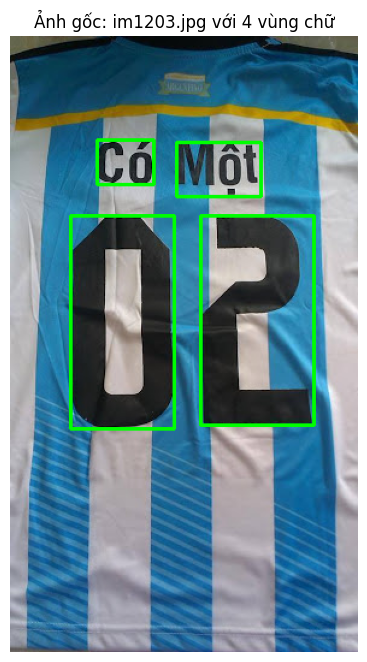

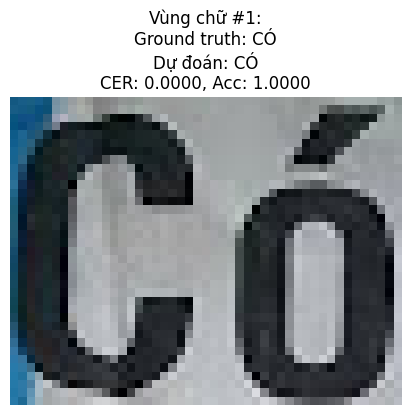

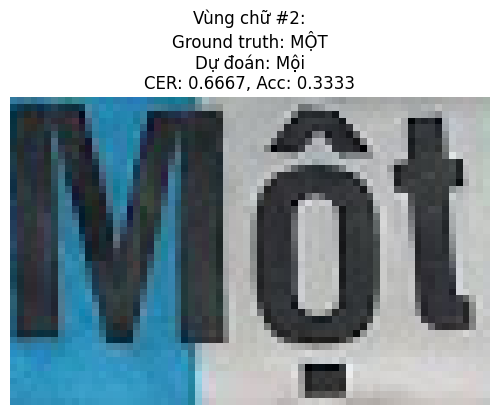

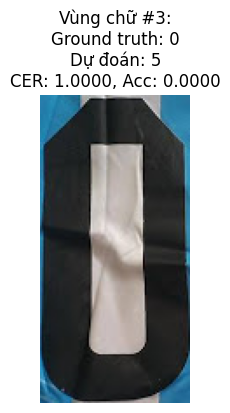

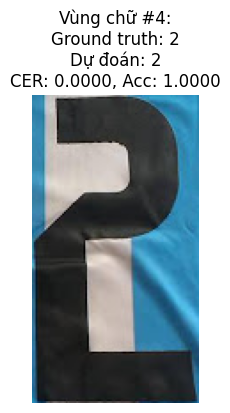


=== Tổng hợp văn bản trong ảnh ===

Văn bản gốc:
--------------------------------------------------
1. CÓ
2. MỘT
3. 0
4. 2

Văn bản dự đoán:
--------------------------------------------------
1. CÓ
2. Mội
3. 5
4. 2

So sánh chi tiết:
--------------------------------------------------
Vùng chữ #1:
- Ground truth: CÓ
- Prediction : CÓ
- Edit distance: 0

Vùng chữ #2:
- Ground truth: MỘT
- Prediction : Mội
- Edit distance: 2

Vùng chữ #3:
- Ground truth: 0
- Prediction : 5
- Edit distance: 1

Vùng chữ #4:
- Ground truth: 2
- Prediction : 2
- Edit distance: 0


=== Kết quả đánh giá ===
Khoảng cách Levenshtein trung bình: 0.7500
Character Error Rate (CER) trung bình: 0.4167
Độ chính xác cấp từ: 0.5000
Độ chính xác cấp ký tự: 0.5833


In [8]:
# Ảnh ví dụ 1
predict_image(os.path.join("vietnamese", "test_image", "im1203.jpg"))

ID ảnh: 1205
Tìm thấy 13 vùng chữ trong ảnh


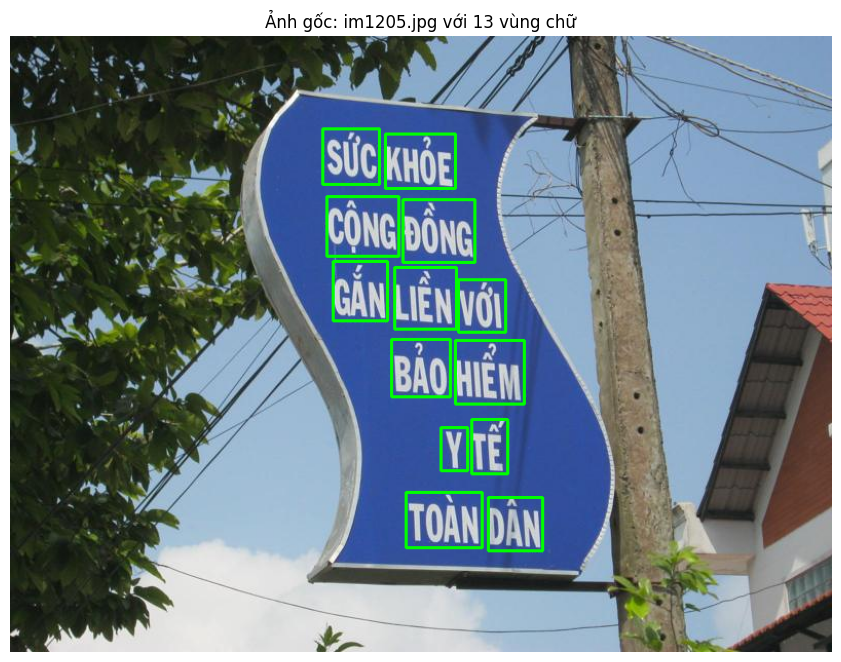

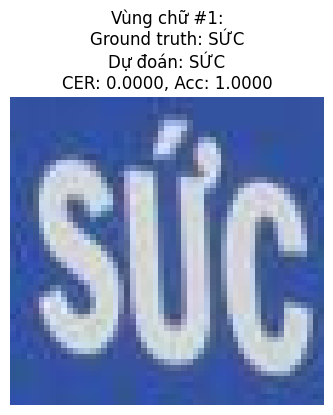

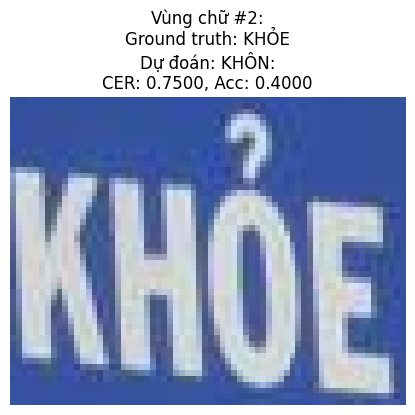

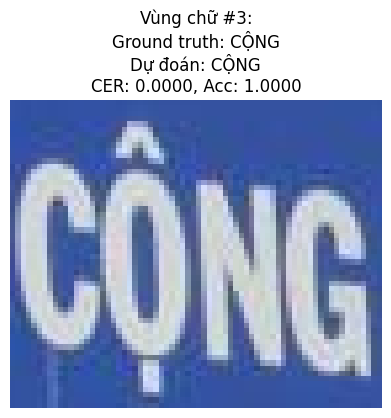

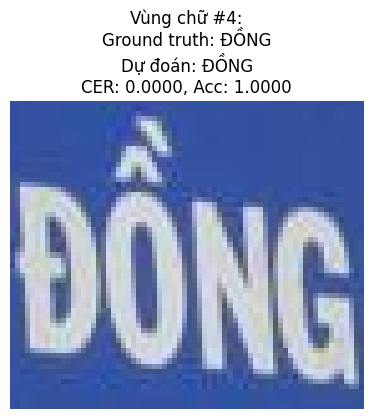

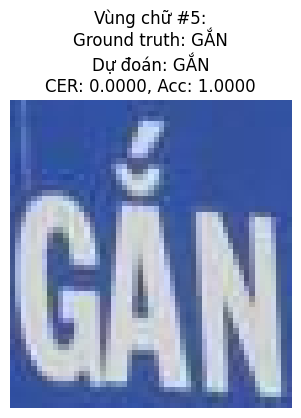

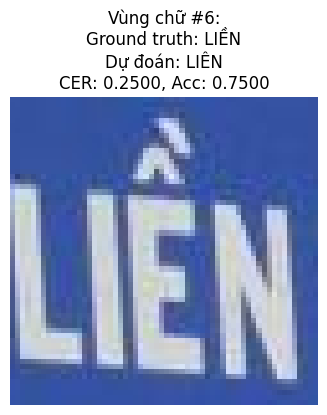

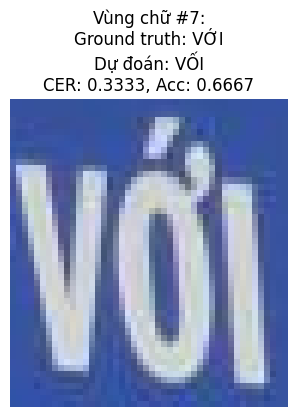

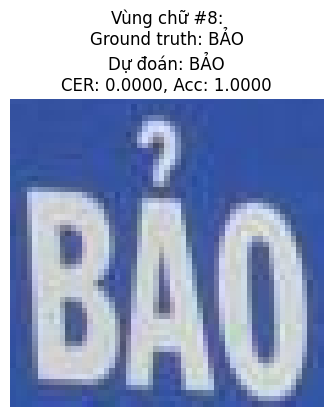

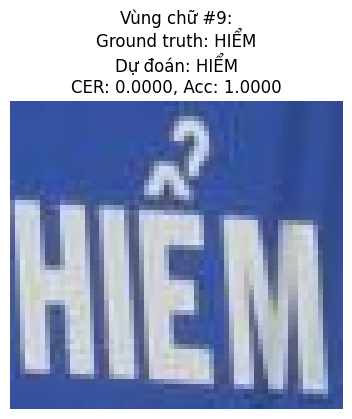

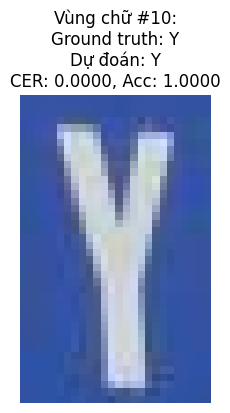

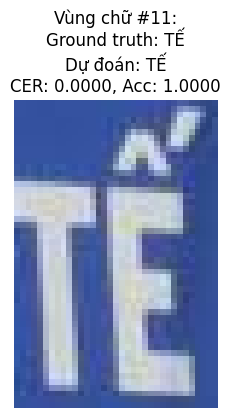

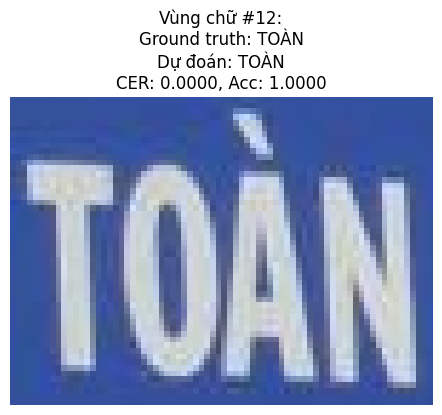

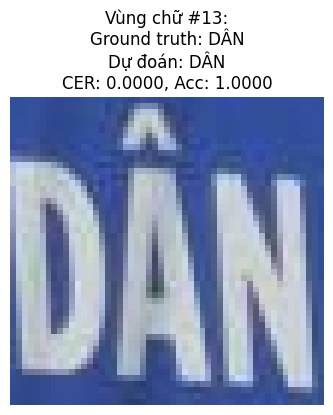


=== Tổng hợp văn bản trong ảnh ===

Văn bản gốc:
--------------------------------------------------
1. SỨC
2. KHỎE
3. CỘNG
4. ĐỒNG
5. GẮN
6. LIỀN
7. VỚI
8. BẢO
9. HIỂM
10. Y
11. TẾ
12. TOÀN
13. DÂN

Văn bản dự đoán:
--------------------------------------------------
1. SỨC
2. KHÔN:
3. CỘNG
4. ĐỒNG
5. GẮN
6. LIÊN
7. VỐI
8. BẢO
9. HIỂM
10. Y
11. TẾ
12. TOÀN
13. DÂN

So sánh chi tiết:
--------------------------------------------------
Vùng chữ #1:
- Ground truth: SỨC
- Prediction : SỨC
- Edit distance: 0

Vùng chữ #2:
- Ground truth: KHỎE
- Prediction : KHÔN:
- Edit distance: 3

Vùng chữ #3:
- Ground truth: CỘNG
- Prediction : CỘNG
- Edit distance: 0

Vùng chữ #4:
- Ground truth: ĐỒNG
- Prediction : ĐỒNG
- Edit distance: 0

Vùng chữ #5:
- Ground truth: GẮN
- Prediction : GẮN
- Edit distance: 0

Vùng chữ #6:
- Ground truth: LIỀN
- Prediction : LIÊN
- Edit distance: 1

Vùng chữ #7:
- Ground truth: VỚI
- Prediction : VỐI
- Edit distance: 1

Vùng chữ #8:
- Ground truth: BẢO
- Prediction : BẢ

In [9]:
# Ảnh ví dụ 2
predict_image(os.path.join("vietnamese", "test_image", "im1205.jpg"))

In [10]:
# # Nhập đường dẫn tùy chọn
# custom_path = input("Nhập đường dẫn đến ảnh: ")
# if os.path.exists(custom_path):
#     predict_image(custom_path)
# else:
#     print(f"Không tìm thấy file: {custom_path}")